In [98]:
import sys
sys.path.append("..")

from pathlib import Path
import random
import datetime
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bold_dementia.data.memento import Memento, MementoTS
from bold_dementia.data.phenotypes import days_to_onset
from bold_dementia.connectivity.atlases import Atlas

CACHE_DIR = Path("/georges/memento/BIDS/derivatives/schaeffer/")
PPATH = Path("/bigdata/jlegrand/data/Memento/output/augmented_phenotypes.csv")

confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}
SOFT = False
ATLAS = "schaeffer"
CLEAN_SIGNAL = True
MACRO_LABELS = True

random.seed(1)

In [99]:
phenotypes = Memento.load_phenotypes(PPATH)

In [100]:
is_converter = phenotypes.declared_dementia.astype(bool).to_list()
days = phenotypes.days_to_onset.to_list()

In [101]:
def days_to_event(phenotypes):
    days_to_event = days_to_onset(
        phenotypes.INCCONSDAT_D,
        phenotypes.DEMENCE_DAT
    )
    # This is awful, we need the actual end of followup
    # to compute right censoring. For now let's pretend that
    # existence of M048 implies no right censoring
    
    end_of_followup = days_to_onset(
        phenotypes.INCCONSDAT_D,
        phenotypes.INCCONSDAT_D + datetime.timedelta(days=phenotypes.days_to_onset.max())
    )

    last_mri = days_to_onset(
        phenotypes.INCCONSDAT_D,
        phenotypes[["M000", "M024"]].max(axis=1)
    )
    

    non_converter_mask = days_to_event.isna()
    right_censored_mask = phenotypes.M048.isna() & non_converter_mask
    
    days_to_event[non_converter_mask] = end_of_followup[non_converter_mask]
    days_to_event[right_censored_mask] = last_mri[right_censored_mask]

    
    return days_to_event

    
phenotypes["days_to_event"] = days_to_event(phenotypes)

In [102]:
from sksurv.datasets import get_x_y

data_x, data_y = get_x_y(
    phenotypes,
    attr_labels=("declared_dementia", "days_to_event"),
    pos_label=1
)

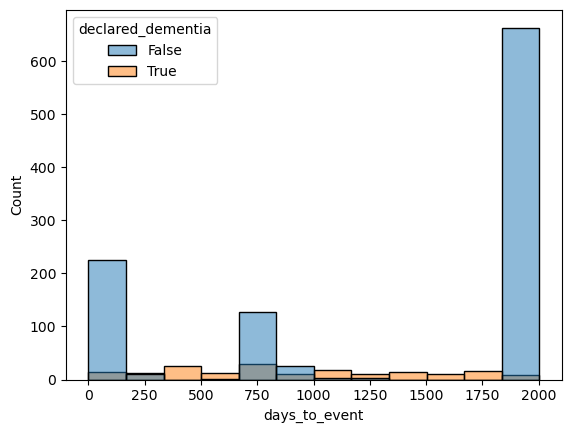

In [103]:
import seaborn as sns
sns.histplot(phenotypes, x="days_to_event", hue="declared_dementia")
plt.show()

In [104]:
days_to_scan = []
for timestep in ("M000", "M024", "M048"):
    days_to_scan.append((phenotypes[timestep] - phenotypes.INCCONSDAT_D).median().days)

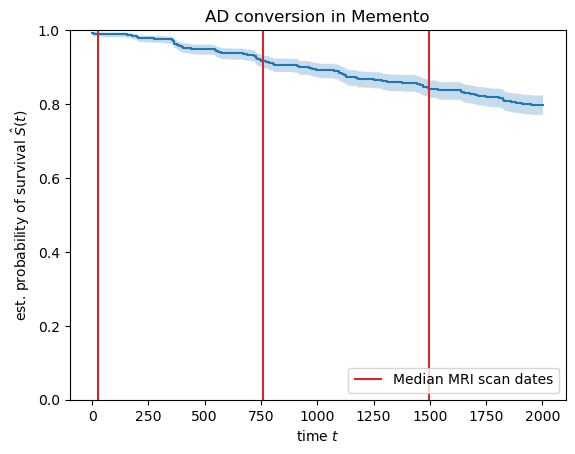

In [105]:
# TODO Give me end of following data PLEASE
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["declared_dementia"], data_y["days_to_event"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)

plt.vlines(days_to_scan, 0, 1, colors="tab:red", label="Median MRI scan dates")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="lower right")
plt.title("AD conversion in Memento")
plt.show()

In [106]:
features = [
    "NIVETUD", "AGE_CONS", "CEN_ANOM", "MCI", "CDRSCR", "APOE_geno", "SEX"
]

In [107]:
data_x[features].head()

,NIVETUD,AGE_CONS,CEN_ANOM,MCI,CDRSCR,APOE_geno,SEX
0,<= BEPC,79.6,EFW,MCI non amnésique pur,0,eps3/eps3,Masculin
1,>BAC,74.4,JGX,MCI amnésique multidomaine,0.5,eps3/eps3,Féminin
2,<= BEPC,70.2,QVM,MCI amnésique multidomaine,0.5,eps3/eps4,Féminin
3,>BAC,77.6,JGX,MCI non amnésique multidomaine,0.5,eps3/eps3,Féminin
4,>BAC,74.1,NRR,MCI non amnésique pur,0.5,eps3/eps4,Féminin


In [108]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer(
    [
        ('categories', OneHotEncoder(dtype='float'), ['NIVETUD', "MCI", "CDRSCR", "CEN_ANOM", "APOE_geno", "SEX"])
    ],
    remainder='passthrough', 
    verbose_feature_names_out=True,
    sparse_threshold=0
)
column_trans

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('categories', OneHotEncoder(dtype='float'),
                                 ['NIVETUD', 'MCI', 'CDRSCR', 'CEN_ANOM',
                                  'APOE_geno', 'SEX'])])

In [109]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(
    StandardScaler(),
    CoxPHSurvivalAnalysis(alpha=0.01)
)

with warnings.catch_warnings(category=FutureWarning, action="ignore"):
    X = column_trans.fit_transform(phenotypes[features])

pipe.fit(X, data_y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxphsurvivalanalysis', CoxPHSurvivalAnalysis(alpha=0.01))])

In [110]:
n_features_out = column_trans.named_transformers_.categories._n_features_outs
macrocats = column_trans.named_transformers_.categories.feature_names_in_.tolist()
op = []
for macrocat, n in zip(macrocats, n_features_out):
    cc = n * [macrocat]
    op += cc

op.append("AGE_CONS")

In [111]:
values = np.hstack(column_trans.named_transformers_.categories.categories_).tolist()
values.append("AGE_CONS")

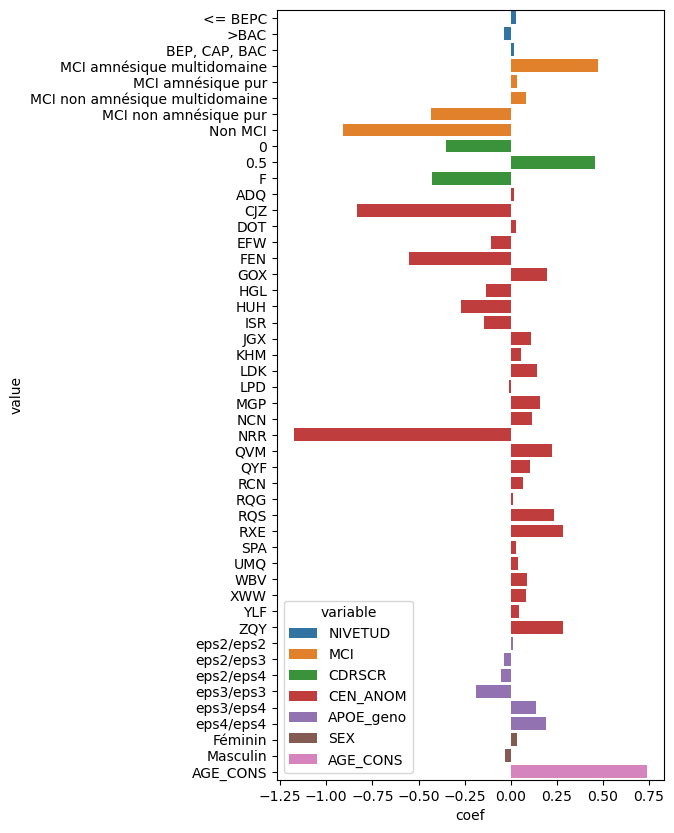

In [116]:
estimator = pipe.named_steps["coxphsurvivalanalysis"]

classifier_beta = pd.DataFrame({
    "value": values,
    "variable": op,
    "coef": estimator.coef_
})

plt.subplots(figsize=(5, 10))
sns.barplot(
    classifier_beta,
    y="value",
    x="coef",
    hue="variable",
    orient="h",
)
plt.show()

In [119]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(X)
result = concordance_index_censored(data_y["declared_dementia"], data_y["days_to_event"], prediction)
result[0]


0.6610203939053281

In [121]:
import numpy as np


def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(X, data_y)
pd.Series(scores, index=classifier_beta.values).sort_values(ascending=False)

(0.5, CDRSCR, 0.45832559949762414)                            0.693002
(0, CDRSCR, -0.3493400186212405)                              0.689525
(MCI amnésique multidomaine, MCI, 0.4740659361915481)         0.679792
(AGE_CONS, AGE_CONS, 0.7367716017362216)                      0.622363
(EFW, CEN_ANOM, -0.1079128188428605)                          0.603468
(MCI non amnésique multidomaine, MCI, 0.08448576125695177)    0.589797
(MCI non amnésique pur, MCI, -0.4324926630958668)             0.583995
(eps3/eps3, APOE_geno, -0.1895209433433511)                   0.577050
(eps3/eps4, APOE_geno, 0.13692690716753553)                   0.571925
(>BAC, NIVETUD, -0.037828131045490626)                        0.570220
(RXE, CEN_ANOM, 0.2830238047039556)                           0.558838
(<= BEPC, NIVETUD, 0.02735545788688734)                       0.548111
(GOX, CEN_ANOM, 0.19616793004835242)                          0.533408
(RQS, CEN_ANOM, 0.23335036918012145)                          0.528987
(Mascu

In [133]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        ("encode", column_trans),
        ("select", SelectKBest(fit_and_score_features, k=3)),
        ("model", CoxPHSurvivalAnalysis(alpha=0.01)),
    ]
)

In [137]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {"select__k": np.arange(1, X.shape[1] + 1)}
gcv = GridSearchCV(pipe, param_grid, return_train_score=True)
with warnings.catch_warnings(category=FutureWarning, action="ignore"):
    gcv.fit(data_x[features], data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sksurv/linear_model/coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packa